<a href="https://colab.research.google.com/github/Tyler9937/DS-Unit-2-Kaggle-Challenge/blob/master/(U2W2A1)assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*


     |████████████████████████████████| 102kB 3.6MB/s 


In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
train2 = train[train['date_recorded'].str.contains('2011|2012')]
val = train[train['date_recorded'].str.contains('2013')]

In [0]:
#creating function to wrangle the data
import numpy as np

def wrangle(x):

  #preventing copy warning
  x = x.copy()

  #referencing lecture notes
  #about 3% of latidude has small values near zero,
  #out side of Tanzania, so we replace these values with zeor.
  x['latitude'] = x['latitude'].replace(-2e-08, 0)

  #some columns will have zeros when they shouldn't, we make these null values
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    x[col] = x[col].replace(0, np.nan)

  x = x.drop(columns='quantity_group')

  #returning the wrangled dataframe
  return x

train = wrangle(train2)
val = wrangle(val)
test = wrangle(test)

In [85]:
#beginning with baselines for classification
target = 'status_group'
y_train = train[target]
y_train.value_counts(normalize=True)

functional                 0.551199
non functional             0.386860
functional needs repair    0.061941
Name: status_group, dtype: float64

In [0]:
#selecting features

#defining the target
target = 'status_group'

#removing target and id in new dataframe
train_features = train.drop(columns=[target, 'id'])

#list of numarical values
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#list of categorical values
cardinality = train_features.select_dtypes(exclude='number').nunique()

#geting list of low cardinality numbers
categorical_features = cardinality[cardinality <= 50].index.tolist()

#merging the lists into features
features = numeric_features + categorical_features

In [0]:
#creating x features matrix and y target vector
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [89]:
#typing out the sklearn base pipline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
  #  StandardScaler(),
    DecisionTreeClassifier(min_samples_leaf=20)
  #  DecisionTreeClassifier(max_depth=16)
)

#fit on training data
pipeline.fit(x_train, y_train)

#score on validation data
print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))


Train Accuracy 0.8124679468915608
Validation Accuracy 0.6333896419595402


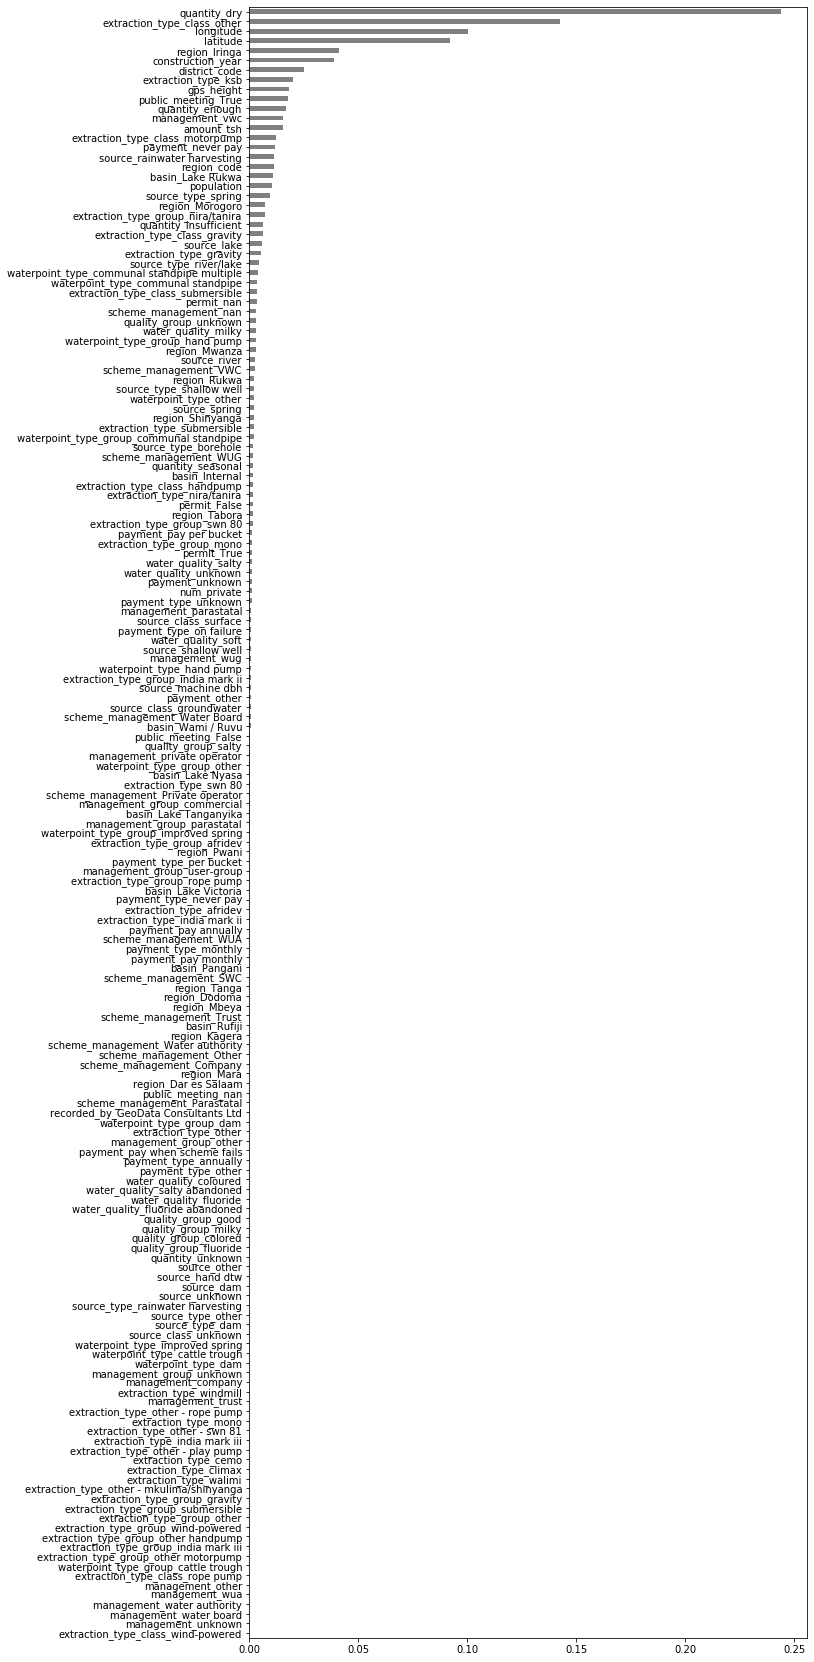

In [67]:
#ploting most importent features

%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(x_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [0]:
y_pred = pipeline.predict(x_test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)

from google.colab import files
files.download('your-submission-filename.csv')